In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
from torchvision.transforms import v2
torch.manual_seed(19)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [2]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(0.4),
    v2.ToDtype(torch.float32)
])


class NMINSTImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy').astype(np.float32)
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        label_temp = np.zeros((10,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
        
    def set_stage(self, stage):
        self.stage = stage

In [3]:
from torch.utils.data import DataLoader
data = NMINSTImageDataset("./Datasety/train_MNIST_EST_exp", transform=transforms)
generator1 = torch.Generator().manual_seed(42)
test_data, training_data = torch.utils.data.random_split(data, [0.3, 0.7], generator=generator1)

del data

In [4]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.hardtanh(out, inplace=False, min_val=-1.0, max_val=1.0)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_chanels = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_chanels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.hardtanh(x)
        x = self.fc2(x)
        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet50_MINST-DVS_Hardtanh_ReLUmaxpool__128x128_FC2_128x128_pretrained_aug_corrected.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}'.format( correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [11]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes = 10).to("cuda")
print(model_resnet)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(10, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=-1.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kern

### Copy weights

In [12]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:

size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(10, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=-1.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Con

In [14]:
torch.autograd.set_detect_anomaly(True)
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=120,save_best=True, save_thr=90)

100%|██████████| 219/219 [01:05<00:00,  3.32it/s]


Epoch [1/120], Step [219/219], Loss: 3.0842, Accuracy: 0.1030
Accuracy of the network: 0.116 Loss: 2.663583070673841


100%|██████████| 219/219 [00:56<00:00,  3.90it/s]


Epoch [2/120], Step [219/219], Loss: 2.3535, Accuracy: 0.1611
Accuracy of the network: 0.185 Loss: 2.2797577317724835


100%|██████████| 219/219 [00:56<00:00,  3.85it/s]


Epoch [3/120], Step [219/219], Loss: 1.9955, Accuracy: 0.2101
Accuracy of the network: 0.19933333333333333 Loss: 1.9215984762983118


100%|██████████| 219/219 [00:56<00:00,  3.90it/s]


Epoch [4/120], Step [219/219], Loss: 1.7856, Accuracy: 0.2713
Accuracy of the network: 0.463 Loss: 1.3431546497852245


100%|██████████| 219/219 [00:55<00:00,  3.91it/s]


Epoch [5/120], Step [219/219], Loss: 1.4493, Accuracy: 0.4284
Accuracy of the network: 0.5566666666666666 Loss: 1.1741107271072713


100%|██████████| 219/219 [00:56<00:00,  3.88it/s]


Epoch [6/120], Step [219/219], Loss: 1.0016, Accuracy: 0.6266
Accuracy of the network: 0.743 Loss: 0.7405856235864314


100%|██████████| 219/219 [00:54<00:00,  3.99it/s]


Epoch [7/120], Step [219/219], Loss: 0.6689, Accuracy: 0.7726
Accuracy of the network: 0.8456666666666667 Loss: 0.4744951495147766


100%|██████████| 219/219 [00:54<00:00,  4.04it/s]


Epoch [8/120], Step [219/219], Loss: 0.4866, Accuracy: 0.8396
Accuracy of the network: 0.8756666666666667 Loss: 0.37735224824319497


100%|██████████| 219/219 [00:54<00:00,  3.99it/s]


Epoch [9/120], Step [219/219], Loss: 0.3618, Accuracy: 0.8847
Accuracy of the network: 0.8866666666666667 Loss: 0.3412674526743432


100%|██████████| 219/219 [00:54<00:00,  3.99it/s]


Epoch [10/120], Step [219/219], Loss: 0.3238, Accuracy: 0.8991
Accuracy of the network: 0.9033333333333333 Loss: 0.2898588623613753


100%|██████████| 219/219 [00:54<00:00,  4.01it/s]


Epoch [11/120], Step [219/219], Loss: 0.2971, Accuracy: 0.9063
Accuracy of the network: 0.9183333333333333 Loss: 0.2564556597870715


100%|██████████| 219/219 [00:54<00:00,  4.03it/s]


Epoch [12/120], Step [219/219], Loss: 0.2675, Accuracy: 0.9167
Accuracy of the network: 0.9116666666666666 Loss: 0.2619182037467018


100%|██████████| 219/219 [00:55<00:00,  3.93it/s]


Epoch [13/120], Step [219/219], Loss: 0.2605, Accuracy: 0.9181
Accuracy of the network: 0.9326666666666666 Loss: 0.21690400503575802


100%|██████████| 219/219 [00:54<00:00,  3.99it/s]


Epoch [14/120], Step [219/219], Loss: 0.2203, Accuracy: 0.9316
Accuracy of the network: 0.94 Loss: 0.19857193109519938


100%|██████████| 219/219 [00:57<00:00,  3.83it/s]


Epoch [15/120], Step [219/219], Loss: 0.2090, Accuracy: 0.9381
Accuracy of the network: 0.9333333333333333 Loss: 0.21114150359434017


100%|██████████| 219/219 [00:55<00:00,  3.92it/s]


Epoch [16/120], Step [219/219], Loss: 0.1917, Accuracy: 0.9417
Accuracy of the network: 0.9433333333333334 Loss: 0.183687141680337


100%|██████████| 219/219 [00:55<00:00,  3.93it/s]


Epoch [17/120], Step [219/219], Loss: 0.1868, Accuracy: 0.9439
Accuracy of the network: 0.928 Loss: 0.2386305725717164


100%|██████████| 219/219 [00:55<00:00,  3.97it/s]


Epoch [18/120], Step [219/219], Loss: 0.1633, Accuracy: 0.9497
Accuracy of the network: 0.953 Loss: 0.15646470833490503


100%|██████████| 219/219 [00:54<00:00,  4.00it/s]


Epoch [19/120], Step [219/219], Loss: 0.1505, Accuracy: 0.9581
Accuracy of the network: 0.9596666666666667 Loss: 0.14984080278651513


100%|██████████| 219/219 [00:55<00:00,  3.96it/s]


Epoch [20/120], Step [219/219], Loss: 0.1395, Accuracy: 0.9607
Accuracy of the network: 0.9653333333333334 Loss: 0.13193075285550762


100%|██████████| 219/219 [00:55<00:00,  3.94it/s]


Epoch [21/120], Step [219/219], Loss: 0.1433, Accuracy: 0.9574
Accuracy of the network: 0.9696666666666667 Loss: 0.11987751785745011


100%|██████████| 219/219 [00:55<00:00,  3.94it/s]


Epoch [22/120], Step [219/219], Loss: 0.1221, Accuracy: 0.9650
Accuracy of the network: 0.9603333333333334 Loss: 0.12820574409387847


100%|██████████| 219/219 [00:55<00:00,  3.95it/s]


Epoch [23/120], Step [219/219], Loss: 0.1124, Accuracy: 0.9707
Accuracy of the network: 0.9693333333333334 Loss: 0.11669642783384374


100%|██████████| 219/219 [00:54<00:00,  4.01it/s]


Epoch [24/120], Step [219/219], Loss: 0.1097, Accuracy: 0.9696
Accuracy of the network: 0.9676666666666667 Loss: 0.121738320612844


100%|██████████| 219/219 [00:55<00:00,  3.97it/s]


Epoch [25/120], Step [219/219], Loss: 0.1108, Accuracy: 0.9689
Accuracy of the network: 0.973 Loss: 0.10112850897093402


100%|██████████| 219/219 [00:55<00:00,  3.94it/s]


Epoch [26/120], Step [219/219], Loss: 0.0930, Accuracy: 0.9747
Accuracy of the network: 0.9716666666666667 Loss: 0.10858924676010266


100%|██████████| 219/219 [00:56<00:00,  3.86it/s]


Epoch [27/120], Step [219/219], Loss: 0.0942, Accuracy: 0.9736
Accuracy of the network: 0.9736666666666667 Loss: 0.09572770397991259


100%|██████████| 219/219 [00:55<00:00,  3.95it/s]


Epoch [28/120], Step [219/219], Loss: 0.0898, Accuracy: 0.9764
Accuracy of the network: 0.971 Loss: 0.10944753871398404


100%|██████████| 219/219 [00:55<00:00,  3.96it/s]


Epoch [29/120], Step [219/219], Loss: 0.0874, Accuracy: 0.9766
Accuracy of the network: 0.9773333333333334 Loss: 0.08822173914535249


100%|██████████| 219/219 [00:55<00:00,  3.98it/s]


Epoch [30/120], Step [219/219], Loss: 0.0775, Accuracy: 0.9807
Accuracy of the network: 0.962 Loss: 0.12870246314621986


100%|██████████| 219/219 [00:54<00:00,  4.00it/s]


Epoch [31/120], Step [219/219], Loss: 0.0800, Accuracy: 0.9783
Accuracy of the network: 0.98 Loss: 0.08524174025242633


100%|██████████| 219/219 [00:55<00:00,  3.94it/s]


Epoch [32/120], Step [219/219], Loss: 0.0784, Accuracy: 0.9794
Accuracy of the network: 0.9716666666666667 Loss: 0.09191046483775085


100%|██████████| 219/219 [00:54<00:00,  4.00it/s]


Epoch [33/120], Step [219/219], Loss: 0.0692, Accuracy: 0.9820
Accuracy of the network: 0.9773333333333334 Loss: 0.08744925806457375


100%|██████████| 219/219 [00:54<00:00,  4.01it/s]


Epoch [34/120], Step [219/219], Loss: 0.0697, Accuracy: 0.9831
Accuracy of the network: 0.9806666666666667 Loss: 0.07851193494539946


100%|██████████| 219/219 [00:54<00:00,  4.03it/s]


Epoch [35/120], Step [219/219], Loss: 0.0704, Accuracy: 0.9806
Accuracy of the network: 0.978 Loss: 0.07981051127129096


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [36/120], Step [219/219], Loss: 0.0642, Accuracy: 0.9837
Accuracy of the network: 0.9763333333333334 Loss: 0.08214594621924644


100%|██████████| 219/219 [00:54<00:00,  3.99it/s]


Epoch [37/120], Step [219/219], Loss: 0.0640, Accuracy: 0.9836
Accuracy of the network: 0.9796666666666667 Loss: 0.07540184391186909


100%|██████████| 219/219 [00:54<00:00,  4.03it/s]


Epoch [38/120], Step [219/219], Loss: 0.0601, Accuracy: 0.9869
Accuracy of the network: 0.9786666666666667 Loss: 0.08259392143326237


100%|██████████| 219/219 [00:55<00:00,  3.95it/s]


Epoch [39/120], Step [219/219], Loss: 0.0622, Accuracy: 0.9841
Accuracy of the network: 0.9803333333333333 Loss: 0.07395367117281607


100%|██████████| 219/219 [00:55<00:00,  3.93it/s]


Epoch [40/120], Step [219/219], Loss: 0.0609, Accuracy: 0.9846
Accuracy of the network: 0.977 Loss: 0.07987596862454047


100%|██████████| 219/219 [00:55<00:00,  3.93it/s]


Epoch [41/120], Step [219/219], Loss: 0.0588, Accuracy: 0.9869
Accuracy of the network: 0.977 Loss: 0.07494416207253457


100%|██████████| 219/219 [00:55<00:00,  3.95it/s]


Epoch [42/120], Step [219/219], Loss: 0.0581, Accuracy: 0.9857
Accuracy of the network: 0.9803333333333333 Loss: 0.07474424962469554


100%|██████████| 219/219 [00:55<00:00,  3.94it/s]


Epoch [43/120], Step [219/219], Loss: 0.0555, Accuracy: 0.9874
Accuracy of the network: 0.9816666666666667 Loss: 0.07533124959135944


100%|██████████| 219/219 [00:55<00:00,  3.94it/s]


Epoch [44/120], Step [219/219], Loss: 0.0518, Accuracy: 0.9890
Accuracy of the network: 0.9796666666666667 Loss: 0.07459991143897493


100%|██████████| 219/219 [00:55<00:00,  3.93it/s]


Epoch [45/120], Step [219/219], Loss: 0.0539, Accuracy: 0.9870
Accuracy of the network: 0.9806666666666667 Loss: 0.07355320267379284


100%|██████████| 219/219 [00:55<00:00,  3.93it/s]


Epoch [46/120], Step [219/219], Loss: 0.0537, Accuracy: 0.9874
Accuracy of the network: 0.9836666666666667 Loss: 0.07190080295178167


100%|██████████| 219/219 [00:56<00:00,  3.90it/s]


Epoch [47/120], Step [219/219], Loss: 0.0525, Accuracy: 0.9883
Accuracy of the network: 0.979 Loss: 0.07440643344431165


100%|██████████| 219/219 [00:56<00:00,  3.87it/s]


Epoch [48/120], Step [219/219], Loss: 0.0528, Accuracy: 0.9871
Accuracy of the network: 0.982 Loss: 0.07030319581006436


100%|██████████| 219/219 [00:56<00:00,  3.88it/s]


Epoch [49/120], Step [219/219], Loss: 0.0487, Accuracy: 0.9894
Accuracy of the network: 0.98 Loss: 0.07109145486251787


100%|██████████| 219/219 [00:57<00:00,  3.84it/s]


Epoch [50/120], Step [219/219], Loss: 0.0482, Accuracy: 0.9890
Accuracy of the network: 0.9806666666666667 Loss: 0.07213087930799798


100%|██████████| 219/219 [00:57<00:00,  3.82it/s]


Epoch [51/120], Step [219/219], Loss: 0.0478, Accuracy: 0.9887
Accuracy of the network: 0.982 Loss: 0.0683362397682318


100%|██████████| 219/219 [00:57<00:00,  3.78it/s]


Epoch [52/120], Step [219/219], Loss: 0.0482, Accuracy: 0.9896
Accuracy of the network: 0.982 Loss: 0.0688489745965505


100%|██████████| 219/219 [00:56<00:00,  3.84it/s]


Epoch [53/120], Step [219/219], Loss: 0.0492, Accuracy: 0.9884
Accuracy of the network: 0.981 Loss: 0.07020407639681658


100%|██████████| 219/219 [00:55<00:00,  3.94it/s]


Epoch [54/120], Step [219/219], Loss: 0.0489, Accuracy: 0.9893
Accuracy of the network: 0.982 Loss: 0.06989072215683917


100%|██████████| 219/219 [00:55<00:00,  3.96it/s]


Epoch [55/120], Step [219/219], Loss: 0.0464, Accuracy: 0.9893
Accuracy of the network: 0.9826666666666667 Loss: 0.06726160195675936


100%|██████████| 219/219 [00:54<00:00,  4.04it/s]


Epoch [56/120], Step [219/219], Loss: 0.0460, Accuracy: 0.9893
Accuracy of the network: 0.9826666666666667 Loss: 0.06908416927376008


100%|██████████| 219/219 [00:53<00:00,  4.06it/s]


Epoch [57/120], Step [219/219], Loss: 0.0448, Accuracy: 0.9899
Accuracy of the network: 0.982 Loss: 0.06892355082635866


100%|██████████| 219/219 [00:54<00:00,  4.04it/s]


Epoch [58/120], Step [219/219], Loss: 0.0451, Accuracy: 0.9910
Accuracy of the network: 0.9823333333333333 Loss: 0.06952759359983053


100%|██████████| 219/219 [00:54<00:00,  4.04it/s]


Epoch [59/120], Step [219/219], Loss: 0.0476, Accuracy: 0.9894
Accuracy of the network: 0.982 Loss: 0.06819201407438898


100%|██████████| 219/219 [00:53<00:00,  4.08it/s]


Epoch [60/120], Step [219/219], Loss: 0.0457, Accuracy: 0.9907
Accuracy of the network: 0.9806666666666667 Loss: 0.06882881389019337


100%|██████████| 219/219 [00:53<00:00,  4.08it/s]


Epoch [61/120], Step [219/219], Loss: 0.0457, Accuracy: 0.9890
Accuracy of the network: 0.9813333333333333 Loss: 0.06904270436535491


100%|██████████| 219/219 [00:53<00:00,  4.08it/s]


Epoch [62/120], Step [219/219], Loss: 0.0446, Accuracy: 0.9903
Accuracy of the network: 0.9813333333333333 Loss: 0.06941997442156711


100%|██████████| 219/219 [00:53<00:00,  4.08it/s]


Epoch [63/120], Step [219/219], Loss: 0.0456, Accuracy: 0.9906
Accuracy of the network: 0.981 Loss: 0.06894481721076559


100%|██████████| 219/219 [00:53<00:00,  4.07it/s]


Epoch [64/120], Step [219/219], Loss: 0.0426, Accuracy: 0.9914
Accuracy of the network: 0.981 Loss: 0.06754181488476535


100%|██████████| 219/219 [00:53<00:00,  4.09it/s]


Epoch [65/120], Step [219/219], Loss: 0.0419, Accuracy: 0.9913
Accuracy of the network: 0.9816666666666667 Loss: 0.06710134384202514


100%|██████████| 219/219 [00:53<00:00,  4.10it/s]


Epoch [66/120], Step [219/219], Loss: 0.0426, Accuracy: 0.9907
Accuracy of the network: 0.982 Loss: 0.06742091312449663


100%|██████████| 219/219 [00:53<00:00,  4.07it/s]


Epoch [67/120], Step [219/219], Loss: 0.0427, Accuracy: 0.9910
Accuracy of the network: 0.9813333333333333 Loss: 0.06576108869085921


100%|██████████| 219/219 [00:53<00:00,  4.09it/s]


Epoch [68/120], Step [219/219], Loss: 0.0434, Accuracy: 0.9909
Accuracy of the network: 0.9823333333333333 Loss: 0.06770298078140997


100%|██████████| 219/219 [00:53<00:00,  4.08it/s]


Epoch [69/120], Step [219/219], Loss: 0.0433, Accuracy: 0.9900
Accuracy of the network: 0.9796666666666667 Loss: 0.06812731479789982


100%|██████████| 219/219 [00:53<00:00,  4.09it/s]


Epoch [70/120], Step [219/219], Loss: 0.0446, Accuracy: 0.9906
Accuracy of the network: 0.9816666666666667 Loss: 0.06664218269090386


100%|██████████| 219/219 [00:53<00:00,  4.08it/s]


Epoch [71/120], Step [219/219], Loss: 0.0428, Accuracy: 0.9910
Accuracy of the network: 0.981 Loss: 0.0674488559226565


100%|██████████| 219/219 [00:53<00:00,  4.09it/s]


Epoch [72/120], Step [219/219], Loss: 0.0439, Accuracy: 0.9911
Accuracy of the network: 0.9833333333333333 Loss: 0.067822067829919


100%|██████████| 219/219 [00:53<00:00,  4.10it/s]


Epoch [73/120], Step [219/219], Loss: 0.0427, Accuracy: 0.9917
Accuracy of the network: 0.9826666666666667 Loss: 0.0655200403490837


100%|██████████| 219/219 [00:53<00:00,  4.06it/s]


Epoch [74/120], Step [219/219], Loss: 0.0415, Accuracy: 0.9914
Accuracy of the network: 0.9806666666666667 Loss: 0.06744080852281223


100%|██████████| 219/219 [00:54<00:00,  4.04it/s]


Epoch [75/120], Step [219/219], Loss: 0.0408, Accuracy: 0.9913
Accuracy of the network: 0.982 Loss: 0.06614225324084784


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [76/120], Step [219/219], Loss: 0.0451, Accuracy: 0.9897
Accuracy of the network: 0.9826666666666667 Loss: 0.06573803337449406


100%|██████████| 219/219 [00:53<00:00,  4.11it/s]


Epoch [77/120], Step [219/219], Loss: 0.0420, Accuracy: 0.9913
Accuracy of the network: 0.9823333333333333 Loss: 0.0661111658221071


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [78/120], Step [219/219], Loss: 0.0427, Accuracy: 0.9906
Accuracy of the network: 0.981 Loss: 0.07058535614348155


100%|██████████| 219/219 [00:53<00:00,  4.11it/s]


Epoch [79/120], Step [219/219], Loss: 0.0421, Accuracy: 0.9916
Accuracy of the network: 0.9813333333333333 Loss: 0.06668692608264849


100%|██████████| 219/219 [00:53<00:00,  4.10it/s]


Epoch [80/120], Step [219/219], Loss: 0.0421, Accuracy: 0.9913
Accuracy of the network: 0.9803333333333333 Loss: 0.06747571702927668


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [81/120], Step [219/219], Loss: 0.0416, Accuracy: 0.9914
Accuracy of the network: 0.982 Loss: 0.06774040608805545


100%|██████████| 219/219 [00:53<00:00,  4.09it/s]


Epoch [82/120], Step [219/219], Loss: 0.0425, Accuracy: 0.9906
Accuracy of the network: 0.9806666666666667 Loss: 0.06836189872565422


100%|██████████| 219/219 [00:53<00:00,  4.10it/s]


Epoch [83/120], Step [219/219], Loss: 0.0443, Accuracy: 0.9901
Accuracy of the network: 0.9806666666666667 Loss: 0.06729363805634227


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [84/120], Step [219/219], Loss: 0.0436, Accuracy: 0.9904
Accuracy of the network: 0.9823333333333333 Loss: 0.06682272336663718


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [85/120], Step [219/219], Loss: 0.0413, Accuracy: 0.9917
Accuracy of the network: 0.9816666666666667 Loss: 0.06740747845949645


100%|██████████| 219/219 [00:53<00:00,  4.13it/s]


Epoch [86/120], Step [219/219], Loss: 0.0432, Accuracy: 0.9901
Accuracy of the network: 0.9806666666666667 Loss: 0.06574637116864324


100%|██████████| 219/219 [00:53<00:00,  4.11it/s]


Epoch [87/120], Step [219/219], Loss: 0.0419, Accuracy: 0.9920
Accuracy of the network: 0.982 Loss: 0.06578361981132246


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [88/120], Step [219/219], Loss: 0.0447, Accuracy: 0.9899
Accuracy of the network: 0.983 Loss: 0.06722214393951792


100%|██████████| 219/219 [00:53<00:00,  4.11it/s]


Epoch [89/120], Step [219/219], Loss: 0.0432, Accuracy: 0.9896
Accuracy of the network: 0.981 Loss: 0.06930298485020374


100%|██████████| 219/219 [00:53<00:00,  4.11it/s]


Epoch [90/120], Step [219/219], Loss: 0.0427, Accuracy: 0.9907
Accuracy of the network: 0.982 Loss: 0.06838146470328595


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [91/120], Step [219/219], Loss: 0.0424, Accuracy: 0.9910
Accuracy of the network: 0.9816666666666667 Loss: 0.06789677884390062


100%|██████████| 219/219 [00:53<00:00,  4.11it/s]


Epoch [92/120], Step [219/219], Loss: 0.0415, Accuracy: 0.9921
Accuracy of the network: 0.9823333333333333 Loss: 0.06913151937794496


100%|██████████| 219/219 [00:53<00:00,  4.13it/s]


Epoch [93/120], Step [219/219], Loss: 0.0401, Accuracy: 0.9916
Accuracy of the network: 0.9806666666666667 Loss: 0.06728953213252603


100%|██████████| 219/219 [00:53<00:00,  4.11it/s]


Epoch [94/120], Step [219/219], Loss: 0.0430, Accuracy: 0.9917
Accuracy of the network: 0.9813333333333333 Loss: 0.06624981094191366


100%|██████████| 219/219 [00:53<00:00,  4.09it/s]


Epoch [95/120], Step [219/219], Loss: 0.0435, Accuracy: 0.9894
Accuracy of the network: 0.9823333333333333 Loss: 0.066825230709931


100%|██████████| 219/219 [00:53<00:00,  4.08it/s]


Epoch [96/120], Step [219/219], Loss: 0.0420, Accuracy: 0.9903
Accuracy of the network: 0.9813333333333333 Loss: 0.06680493688884567


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [97/120], Step [219/219], Loss: 0.0446, Accuracy: 0.9910
Accuracy of the network: 0.9836666666666667 Loss: 0.06581426726931587


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [98/120], Step [219/219], Loss: 0.0409, Accuracy: 0.9914
Accuracy of the network: 0.9836666666666667 Loss: 0.06603762832410792


100%|██████████| 219/219 [00:53<00:00,  4.09it/s]


Epoch [99/120], Step [219/219], Loss: 0.0444, Accuracy: 0.9893
Accuracy of the network: 0.981 Loss: 0.06770371245418458


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [100/120], Step [219/219], Loss: 0.0423, Accuracy: 0.9919
Accuracy of the network: 0.9813333333333333 Loss: 0.06578021164626834


100%|██████████| 219/219 [00:53<00:00,  4.11it/s]


Epoch [101/120], Step [219/219], Loss: 0.0405, Accuracy: 0.9921
Accuracy of the network: 0.9826666666666667 Loss: 0.06649316762118264


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [102/120], Step [219/219], Loss: 0.0423, Accuracy: 0.9911
Accuracy of the network: 0.9816666666666667 Loss: 0.06675705825909972


100%|██████████| 219/219 [00:53<00:00,  4.10it/s]


Epoch [103/120], Step [219/219], Loss: 0.0418, Accuracy: 0.9909
Accuracy of the network: 0.9833333333333333 Loss: 0.06590412536318949


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [104/120], Step [219/219], Loss: 0.0391, Accuracy: 0.9923
Accuracy of the network: 0.983 Loss: 0.06687865139758016


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [105/120], Step [219/219], Loss: 0.0451, Accuracy: 0.9890
Accuracy of the network: 0.9823333333333333 Loss: 0.06670050615286256


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [106/120], Step [219/219], Loss: 0.0390, Accuracy: 0.9936
Accuracy of the network: 0.981 Loss: 0.06892968933197095


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [107/120], Step [219/219], Loss: 0.0429, Accuracy: 0.9914
Accuracy of the network: 0.9803333333333333 Loss: 0.06953061231352547


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [108/120], Step [219/219], Loss: 0.0389, Accuracy: 0.9919
Accuracy of the network: 0.982 Loss: 0.06872904115415951


100%|██████████| 219/219 [00:53<00:00,  4.11it/s]


Epoch [109/120], Step [219/219], Loss: 0.0428, Accuracy: 0.9903
Accuracy of the network: 0.982 Loss: 0.0665010334527556


100%|██████████| 219/219 [00:53<00:00,  4.10it/s]


Epoch [110/120], Step [219/219], Loss: 0.0411, Accuracy: 0.9921
Accuracy of the network: 0.9816666666666667 Loss: 0.06694665774108564


100%|██████████| 219/219 [00:53<00:00,  4.09it/s]


Epoch [111/120], Step [219/219], Loss: 0.0435, Accuracy: 0.9906
Accuracy of the network: 0.9803333333333333 Loss: 0.06899763271212578


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [112/120], Step [219/219], Loss: 0.0404, Accuracy: 0.9911
Accuracy of the network: 0.9823333333333333 Loss: 0.06647674589754736


100%|██████████| 219/219 [00:53<00:00,  4.10it/s]


Epoch [113/120], Step [219/219], Loss: 0.0421, Accuracy: 0.9904
Accuracy of the network: 0.982 Loss: 0.06844151754209653


100%|██████████| 219/219 [00:53<00:00,  4.11it/s]


Epoch [114/120], Step [219/219], Loss: 0.0403, Accuracy: 0.9917
Accuracy of the network: 0.982 Loss: 0.06567099022659216


100%|██████████| 219/219 [00:53<00:00,  4.09it/s]


Epoch [115/120], Step [219/219], Loss: 0.0393, Accuracy: 0.9926
Accuracy of the network: 0.9813333333333333 Loss: 0.06699780883029738


100%|██████████| 219/219 [00:53<00:00,  4.10it/s]


Epoch [116/120], Step [219/219], Loss: 0.0443, Accuracy: 0.9903
Accuracy of the network: 0.981 Loss: 0.06621835246048074


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [117/120], Step [219/219], Loss: 0.0418, Accuracy: 0.9906
Accuracy of the network: 0.983 Loss: 0.06574084881217555


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [118/120], Step [219/219], Loss: 0.0402, Accuracy: 0.9927
Accuracy of the network: 0.983 Loss: 0.06680225920764372


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [119/120], Step [219/219], Loss: 0.0421, Accuracy: 0.9906
Accuracy of the network: 0.9806666666666667 Loss: 0.06709294411492475


100%|██████████| 219/219 [00:53<00:00,  4.09it/s]


Epoch [120/120], Step [219/219], Loss: 0.0427, Accuracy: 0.9920
Accuracy of the network: 0.982 Loss: 0.0687897378043767


In [15]:
torch.save(model, "best_resnet50_MINST-DVS_Hardtanh_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected.pt")


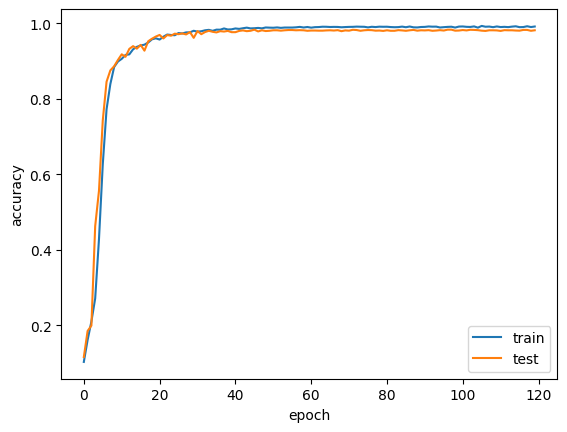

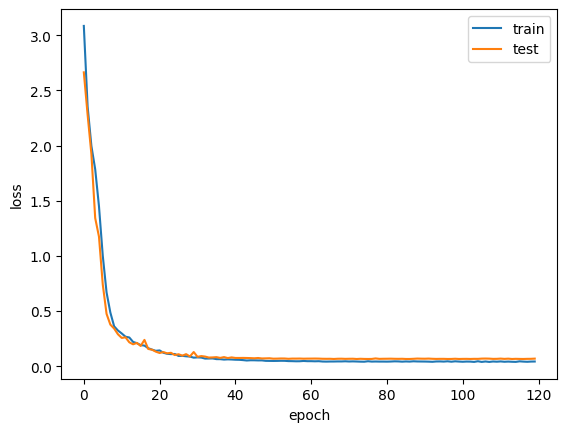

In [16]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [17]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet50_MINST-DVS_Hardtanh_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected.csv')

In [18]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.103000,0.116000,3.084173,2.663583
1,0.161143,0.185000,2.353523,2.279758
2,0.210143,0.199333,1.995460,1.921598
3,0.271286,0.463000,1.785553,1.343155
4,0.428429,0.556667,1.449273,1.174111
